In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path
import matplotlib.patches as patches
import requests
from bs4 import BeautifulSoup
import io
from csv import writer
import re
import seaborn as sns
import cartopy.crs as ccrs
import cartopy

In [2]:
ihsa_raw = pd.read_csv('IHSA_Deposit.csv', keep_default_na = False, na_values = '', dtype = {"YEAR":int, "LAT":float, "LONG":float})

In [3]:
ihsa_raw.head()

,ABBR,DIV,YEAR,PLACE,TOURNAMENT,SCORE,SCHOOL,ID,LAT,LONG,EXACT,SIZE,CONF,TYPE,COUNTY,BRD-DIV,LG-DT,OPEN
0,bwb,N/A,2003,1,False,13064.0,Rockford (Jefferson),1824.0,42.2074,-89.0377,True,1656.0,Northern Illinois (NIC-10),Public Coed,Winnebago,4.0,10.0,True
1,bwb,N/A,2003,2,False,12987.0,Freeport (H.S.),619.0,42.2886,-89.6288,True,1173.5,Northern Illinois (NIC-10),Public Coed,Stephenson,4.0,10.0,True
2,bwb,N/A,2003,3,False,12667.0,Collinsville,343.0,38.6469,-90.0110,True,1904.5,Southwestern,Public Coed,St. Clair,7.0,19.0,True
3,bwb,N/A,2003,4,False,12665.0,Oak Lawn (Community),1502.0,41.7212,-87.7678,True,1774.5,South Suburban,Public Coed,Cook,3.0,8.0,True
4,bwb,N/A,2003,5,False,12664.0,Alton (Sr.),110.0,38.9364,-90.1581,True,2008.0,Southwestern,Public Coed,Madison,7.0,19.0,True


In [4]:
print(ihsa_raw[ihsa_raw["LAT"].isna()].equals(ihsa_raw[ihsa_raw["LAT"].isna()]))
ihsa_raw_problems = ihsa_raw[ihsa_raw["LAT"].isna()]

display(ihsa_raw_problems[["ABBR", "DIV", "YEAR", "PLACE", "SCORE", "SCHOOL"]])

True


,ABBR,DIV,YEAR,PLACE,SCORE,SCHOOL
1971,gob,A,1983,2,NaN,vacated
9437,chc,C,2015,5,NaN,vacated
16482,mu,A,1991,9,576.0,unknown (NOT Ottawa)
17539,mu,B,2012,3,792.0,vacated


In [5]:
print(ihsa_raw.shape)
print(ihsa_raw[(ihsa_raw["ABBR"] == "WR") & (ihsa_raw["YEAR"].astype(int) >= 1984)].shape)

(36074, 18)
(0, 18)


In [6]:
ihsa_tidy = ihsa_raw.drop(ihsa_raw[(ihsa_raw["ABBR"] == "WR") & (ihsa_raw["YEAR"].astype(int) >= 1984)].index)
print(ihsa_tidy.shape)

(36074, 18)


In [7]:
def divpts(div, abbr, year):
    if div == "N/A": divpts = 0
    elif div == "A":
        if abbr not in ["TRB", "MU"]: divpts = 1
        elif abbr == "TRB":
            if year > 1926: divpts = 1
            elif year != 1916: divpts = 2
            else: divpts = 3
        else: divpts = 4
    elif div == "AA":
        if abbr !="MU": divpts=2
        else: divpts = 5
    elif re.match("\d", div[0]): divpts = int(div[0])
    elif div == "B":
        if abbr == "TRB":
            if year != 1916: divpts = 1
            else: divpts = 2
        else:
            divpts = 3
    elif div == "C" and abbr == "CHC": divpts = 0
    elif div == "C" and abbr == "TRB": divpts = 1
    elif div == "C": divpts = 2
    elif div == "D": divpts = 1
    elif div == "S": divpts = 1
    elif div == "M": divpts = 2
    elif div == "L": divpts = 3
    else: divpts = -1
    return divpts
    
def global_div(div, abbr, year):
    this_pts = divpts(div, abbr, year)
    maxpts = ihsa_tidy[(ihsa_tidy["ABBR"]==abbr) & (ihsa_tidy["YEAR"]==year)]["DIV"].copy().apply(lambda x: divpts(x, abbr, year)).max()
    if maxpts == -1: return "-1"
    if this_pts == 0: return "0"
    return str(this_pts) + "/" + str(maxpts)

In [8]:
ihsa_tidy["ABBR"] = ihsa_tidy["ABBR"].astype(str).apply(lambda x: x.upper())
ihsa_tidy["YEAR"] = ihsa_tidy["YEAR"].astype(int)
ihsa_tidy = ihsa_tidy[~ ihsa_tidy["LAT"].isna()]
ihsa_tidy["GL_DIV"] = ihsa_tidy.apply(lambda x: global_div(x["DIV"], x["ABBR"], x["YEAR"]), axis = 1)

In [9]:
ihsa_tidy[ihsa_tidy["ABBR"]=="FB"].head()

,ABBR,DIV,YEAR,PLACE,TOURNAMENT,SCORE,SCHOOL,ID,LAT,LONG,EXACT,SIZE,CONF,TYPE,COUNTY,BRD-DIV,LG-DT,OPEN,GL_DIV
27448,FB,1A,1975,Semifinals,True,3.0,Genoa (G.-Kingston),708.0,42.097400,-88.718100,True,594.5,Big Northern,Public Coed,DeKalb,2.0,5.0,True,1/5
27449,FB,1A,1975,Preliminary Round,True,1.0,Milledgeville,1332.0,41.967000,-89.772000,True,167.0,Northwest Upstate Illini,Public Coed,Carroll,4.0,10.0,True,1/5
27450,FB,1A,1975,Quarterfinals,True,2.0,LaMoille,1208.0,41.524000,-89.280100,True,88.0,Little Ten,Public Coed,Bureau,4.0,11.0,True,1/5
27451,FB,1A,1975,Preliminary Round,True,1.0,Princeville,1643.0,40.932000,-89.753200,True,230.0,Lincoln Trail,Public Coed,Peoria,4.0,12.0,True,1/5
27452,FB,1A,1975,Champion,True,5.0,Flanagan,NaN,40.877206,-88.859961,True,NaN,NaN,NaN,NaN,NaN,NaN,False,1/5


In [10]:
il_pop = pd.read_excel('il_pop_data.xlsx', sheet_name='results')
il_pop.rename(columns = {'Unnamed: 0':'Year', 'lat':'Lat', 'long':'Long'}, inplace = True)
pre_il_pop = il_pop.copy()
temp = []
for year in range(1900, 2011):
    if year % 10 == 0: temp.append(il_pop.iloc[int((year-1900)/10)].to_numpy())
    else: temp.append(np.array([np.nan, np.nan, np.nan]))
il_pop = pd.DataFrame(temp, columns = ["Year", "Lat", "Long"]).interpolate()
il_pop["Year"] = il_pop["Year"].astype(int)

In [11]:
ihsa_tidy["ABBR"].unique()

array(['BWB', 'CCB', 'GOB', 'GYB', 'SWB', 'TNB', 'TRB', 'WR', 'BAD',
       'BWL', 'CHC', 'CCG', 'GOG', 'GYG', 'SWG', 'TNG', 'TRG', 'DAC',
       'BSF', 'CT', 'IE', 'JRN', 'MU', 'DR', 'GI', 'BA', 'LCB', 'SOB',
       'WPB', 'BKG', 'LCG', 'SOG', 'SBG', 'WPG', 'SCB', 'VBB', 'VBG',
       'BKB', 'FB'], dtype=object)

In [12]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def draw_arrows(mydata, coloring, scale): #mydata = vals[div] for some div
    hh = 0.015
    for i in range(mydata.shape[0]-1):
        long1 = mydata.iloc[i]["Long"]
        lat1 = mydata.iloc[i]["Lat"]
        arrow_base_long = long1 + (mydata.iloc[i+1]["Long"]-mydata.iloc[i]["Long"])/2
        arrow_base_lat = lat1 + (mydata.iloc[i+1]["Lat"]-mydata.iloc[i]["Lat"])/2
        theta = np.arctan(abs(arrow_base_lat-lat1)/abs(arrow_base_long-long1))
        if long1> arrow_base_long:
            if lat1 < arrow_base_lat:
                rot = 90-np.degrees(theta)
            else:
                rot = 90+np.degrees(theta)
        else:
            if lat1 < arrow_base_lat:
                rot = -(90-np.degrees(theta))
            else:
                rot = -(90+np.degrees(theta))
        plt.plot(arrow_base_long, arrow_base_lat, marker=(3, 0, rot), markersize=scale*12, linestyle='None', color = lighten_color(coloring, 0.5))
        
def plot_points(mydatas, name, connected = False, coloring = "black", size = 50, scale = 1):
    for i in range(len(mydatas)):
        mydata = mydatas[i]
        s = scale*size/25
        plt.plot("Long", "Lat", data = mydata, linestyle='--' if connected else 'None', markersize=s*10, linewidth = s*1.5, color = coloring)
        if connected: draw_arrows(mydata, coloring, s)
        if mydata.shape[0] > 1:
            named, = plt.plot("Long", "Lat", data = mydata.iloc[1:-1], marker='o', markersize=s*10, linewidth = 0, color = coloring, label = name)
            plt.plot("Long", "Lat", data = mydata.iloc[0], marker='D', markersize=s*12, color = coloring)
            plt.plot("Long", "Lat", data = mydata.iloc[-1], marker='X', markersize=s*15, color = coloring)
            if i == len(mydatas)-1: return named
        elif mydata.shape[0] == 1:
            named, = plt.plot("Long", "Lat", data = mydata.iloc[0], marker='o', markersize=s*10, linewidth = 0, color = coloring, label = name)
            if i == len(mydatas)-1: return named

In [14]:
nontournaments = ["bwb", "ccb", "gob", "gyb", "swb", "tnb", "trb", "bad", "bwl", "chc", "ccg", "gog", "gyg", "swg", "tng", "trg", "dac", "bsf", "ct", "ie", "jrn", "mu"] 
nontournaments = [x.upper() for x in nontournaments]

def return_data(ihsa_subset, weighting = "equal", window = 1, to_graph = True):
    metadata = {}
    goods = {}
    count = 0
    for abbr in ihsa_subset["ABBR"].unique():
        this_activity = ihsa_subset[ihsa_subset["ABBR"] == abbr.upper()]
        pos_by_div = {}

        year = this_activity["YEAR"].min()

        goodyears = []
        while year <= this_activity["YEAR"].max() - window + 1:
            firstyear = year
            divs = list(this_activity[this_activity["YEAR"] == year]["DIV"].unique())
            newdivs = divs
            penalty = 0
            potential_goods = []
            while np.array_equal(newdivs, divs) or newdivs == [] or (len(newdivs) == len(divs) == 1):
                if newdivs == []: penalty += 1
                if year-firstyear >= (window + penalty) - 1: potential_goods.append(year)
                year += 1
                if year > this_activity["YEAR"].max(): break
                newdivs = list(this_activity[this_activity["YEAR"] == year]["DIV"].unique())
                
            if year-firstyear < (window + penalty):
                this_activity = this_activity[~((this_activity["YEAR"] >= firstyear) & (this_activity["YEAR"] < year))]
            else:
                goodyears.extend(potential_goods)
        this_activity = this_activity[~ (this_activity["YEAR"] >= year)]
        
        for year in this_activity["YEAR"].unique():
            this_year_activity = this_activity[this_activity["YEAR"] == year].copy()
            if not to_graph: this_year_activity["DIV"] = this_year_activity["GL_DIV"]
            for div in this_year_activity["DIV"].unique():
                div_year_abbr = this_year_activity[this_year_activity["DIV"] == div].copy()
                
                if weighting == "equal":
                    lat = (div_year_abbr["LAT"]/div_year_abbr.shape[0]).sum()
                    long = (div_year_abbr["LONG"]/div_year_abbr.shape[0]).sum()
                elif weighting == "place":
                    div_year_abbr["PLACE"] = pd.to_numeric(div_year_abbr["PLACE"], downcast='integer')
                    control = div_year_abbr["PLACE"].max() + 1
                    lat = ((control-div_year_abbr["PLACE"])/(control-div_year_abbr["PLACE"]).sum()*div_year_abbr["LAT"]).sum()
                    long = ((control-div_year_abbr["PLACE"])/(control-div_year_abbr["PLACE"]).sum()*div_year_abbr["LONG"]).sum()
                elif weighting == "score":
                    div_year_abbr["SCORE"] = pd.to_numeric(div_year_abbr["SCORE"], downcast='float')
                    lat = ((div_year_abbr["SCORE"])/(div_year_abbr["SCORE"].sum())*div_year_abbr["LAT"]).sum()
                    long = ((div_year_abbr["SCORE"])/(div_year_abbr["SCORE"].sum())*div_year_abbr["LONG"]).sum()
                else:
                    raise Exception("Input weighting method was not found.")
                
                if div in pos_by_div.keys():
                    pos_by_div[div].append([year, lat, long])
                else:
                    pos_by_div[div] = []
                    pos_by_div[div].append([year, lat, long])

        for div in list(pos_by_div.keys()).copy():
            if len(pos_by_div[div]) < window:
                del pos_by_div[div]
            else:
                new_entry = []
                for i in range(len(pos_by_div[div]) - window + 1):
                    moving_avg = np.array([0, 0, 0])
                    for j in range(window):
                        moving_avg = np.add(moving_avg, np.array(pos_by_div[div][i + j]))
                    moving_avg = moving_avg / window
                    new_entry.append([pos_by_div[div][i+j][0], np.asarray(moving_avg)[1], np.asarray(moving_avg)[2]])
                    count += 1
                pos_by_div[div] = new_entry
                
        metadata[abbr] = pos_by_div
        goods[abbr] = goodyears
    return metadata, goods

def return_graphs(ihsa_subset, weighting = "equal", connected = False, window = 1, show_map = True, figsize = 15, scale = 1):
    metadata, goods = return_data(ihsa_subset, weighting = weighting, window = window)
    for abbr in metadata.keys():
        goodyears = goods[abbr]
        pos_by_div = metadata[abbr]
        colors = matplotlib.cm.get_cmap('tab10').colors
        plt.figure(figsize=(figsize, figsize))
        
        if show_map:
            ax = plt.axes(projection=ccrs.PlateCarree())
            ax.set_extent([-87.4, -91.7, 36.8, 42.7], ccrs.PlateCarree())
        
        legend_labels = []
        for div, color in zip(pos_by_div.keys(), colors):
            data = pd.DataFrame(pos_by_div[div], columns = ["Year", "Lat", "Long"])
            mydatas= []
            badindicies = list(data[~ data["Year"].isin(goodyears)].index)
            if len(badindicies) > 0:
                mydatas.append(data.iloc[0:badindicies[0]])
                prev_bad = badindicies[0]
                for index in badindicies[1:]:
                    temp = data.iloc[prev_bad + 1: index]
                    prev_bad = index
                    if not temp.empty: mydatas.append(temp)
                temp = data.iloc[prev_bad + 1:]
                if not temp.empty: mydatas.append(temp)
            else:
                mydatas.append(data)

            legend_labels.append(plot_points(mydatas, div, coloring=color, connected = connected, size = figsize, scale = scale))
        
        if show_map: ax.add_feature(cartopy.feature.STATES)
        legend_labels = [x for x in legend_labels if x is not None]
        plt.legend(handles = legend_labels, title = "Division")
        plt.title(str(window) + "-Year Window of " + abbr + " Placers, Weighting = " + weighting[0].upper() + weighting[1:])
        plt.show()

In [85]:
from scipy.spatial import distance as spdistance

def cos_to_chi(returned_data, goods):
    abbrs_data = {}
    for abbr in returned_data.keys():
        divs_data = {}
        goodyears = goods[abbr]
        for div in returned_data[abbr].keys():
            data = pd.DataFrame(returned_data[abbr][div], columns = ["Year", "Lat", "Long"])
            yr_lt_lg = data[data["Year"].isin(goodyears)].to_numpy()
            cos_thetas = []
            for i in range(len(yr_lt_lg)-1):
                actual = np.array(yr_lt_lg[i+1][1:])-np.array(yr_lt_lg[i][1:])
                to_chi = np.array([41.89188058418812, -87.59885261325608]) -np.array(yr_lt_lg[i][1:])
                if np.dot(actual, to_chi) == 0: cos_theta = 0
                else: cos_theta = 1-spdistance.cosine(actual, to_chi)
                cos_thetas.append([int(yr_lt_lg[i+1][0]), cos_theta])
            divs_data[div] = cos_thetas
        abbrs_data[abbr] = divs_data
    return abbrs_data

def cos_to_il_pop(returned_data, goods):
    abbrs_data = {}
    for abbr in returned_data.keys():
        divs_data = {}
        goodyears = goods[abbr]
        for div in returned_data[abbr].keys():
            data = pd.DataFrame(returned_data[abbr][div], columns = ["Year", "Lat", "Long"])
            yr_lt_lg = data[data["Year"].isin(goodyears)].to_numpy()
            cos_thetas = []
            for i in range(len(yr_lt_lg)-1):
                if int(yr_lt_lg[i][0]) not in list(il_pop["Year"]) or int(yr_lt_lg[i+1][0]) not in list(il_pop["Year"]): continue
                actual = np.array(yr_lt_lg[i+1][1:])-np.array(yr_lt_lg[i][1:])
                il_pop_prev = il_pop.loc[il_pop["Year"]==int(yr_lt_lg[i][0])].to_numpy()[0]
                il_pop_curr = il_pop.loc[il_pop["Year"]==int(yr_lt_lg[i+1][0])].to_numpy()[0]
                il_pop_delta = np.array((il_pop_curr-il_pop_prev)[1:])
                if np.dot(actual, il_pop_delta) == 0: cos_theta = 0
                else: cos_theta = 1-spdistance.cosine(actual, il_pop_delta)
                cos_thetas.append([int(yr_lt_lg[i+1][0]), cos_theta])
            divs_data[div] = cos_thetas
        abbrs_data[abbr] = divs_data
    return abbrs_data

def avg_cos_to_plotter(ihsa_subset, absolute_time, to_chi = True, by = None, plot_type = 1, normalized = False, window = 1):
    '''
    plot type of 0 gives a cumulative average of avg over "by" per year
    plot type of n>0 gives an n-year moving average of avg over "by" per year
    therefore a plot type of 1 gives just an avg over "by" per year
    '''
    metadata, goodyears = return_data(ihsa_subset, window = window, to_graph = False)
    returned_data = cos_to_chi(metadata, goodyears) if to_chi else cos_to_il_pop(metadata, goodyears)
    metadata = []
    
    for abbr in returned_data.keys():
        for div in returned_data[abbr].keys():
            for yr_cos in returned_data[abbr][div]:
                year = yr_cos[0] - (0 if absolute_time else (returned_data[abbr][div][0][0] - 1))
                cos = yr_cos[1]
                #new_div = global_div(div, abbr, yr_cos[0])
                divtf = False if div == "0" else True
                metadata.append([cos, year, abbr, div, divtf])
    metadata = pd.DataFrame(metadata, columns = ["cos", "year", "abbr", "global_div", "divisions?"])

    if by is None:
        print(metadata.shape[0])
        print(metadata["cos"].mean(), metadata["cos"].std())
        if plot_type == 0:
            new_meta = []
            for year in metadata["year"].unique():
                subset = metadata[metadata["year"]<=year]
                if normalized:
                    mean = 0
                    for abbr in subset["abbr"].unique():
                        mean += subset[subset["abbr"]==abbr]["cos"].mean()
                    mean = mean / len(subset["abbr"].unique())
                else: mean = subset["cos"].mean()
                new_meta.append([mean, year])
            metadata = pd.DataFrame(new_meta, columns = ["cos", "year"])
        elif plot_type > 0:
            new_meta = []
            for year in metadata["year"].unique():
                subset = metadata[(metadata["year"]<=year) & (metadata["year"]>year-plot_type)]
                if normalized:
                    mean = 0
                    for abbr in subset["abbr"].unique():
                        mean += subset[subset["abbr"]==abbr]["cos"].mean()
                    mean = mean / len(subset["abbr"].unique())
                else: mean = subset["cos"].mean()
                new_meta.append([mean, year])
            metadata = pd.DataFrame(new_meta, columns = ["cos", "year"])
    else:
        if by == "divisions?":
            print(metadata[metadata[by]].shape[0], metadata[~ metadata[by]].shape[0])
            print(metadata[metadata[by]]["cos"].mean(), metadata[~ metadata[by]]["cos"].mean())
            print(metadata[metadata[by]]["cos"].std(), metadata[~ metadata[by]]["cos"].std())
        if plot_type == 0:
            new_meta = []
            for key in metadata[by].unique():
                subset = metadata[metadata[by]==key]
                for year in subset["year"].unique():
                    subset2 = subset[subset["year"]<=year]
                    mean = subset2["cos"].mean()
                    new_meta.append([mean, year, key])
            metadata = pd.DataFrame(new_meta, columns = ["cos", "year", "key"])
        elif plot_type > 0:
            new_meta = []
            for key in metadata[by].unique():
                subset = metadata[metadata[by]==key]
                for year in subset["year"].unique():
                    subset2 = subset[(subset["year"]<=year) & (subset["year"]>year-plot_type)]
                    mean = subset2["cos"].mean()
                    new_meta.append([mean, year, key])
            metadata = pd.DataFrame(new_meta, columns = ["cos", "year", "key"])
    return metadata

2032
705 744
0.0141429537810602 0.04581794884815436
0.7280000912727594 0.7637758875122062


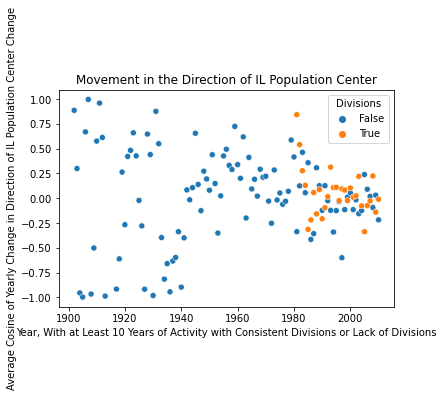

2032
705 744
0.0141429537810602 0.04581794884815436
0.7280000912727594 0.7637758875122062


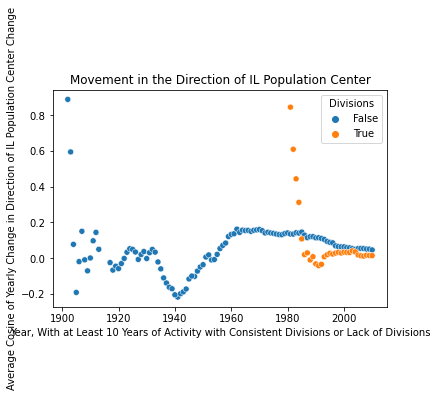

2032
1449
0.030406719364164423 0.7464944515872796


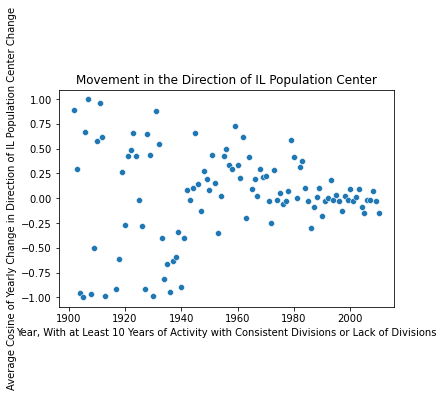

2032
1449
0.030406719364164423 0.7464944515872796


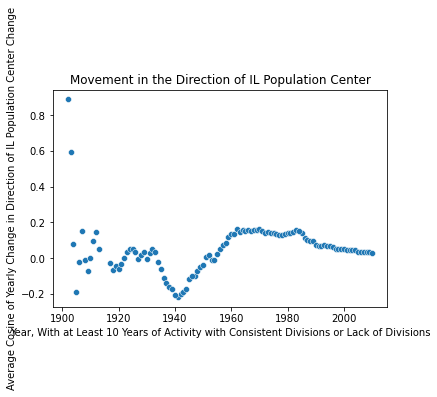

In [86]:
dataset = avg_cos_to_plotter(ihsa_tidy, True, to_chi = False, by = "divisions?", plot_type = 1, window = 9)
dataset.columns = ["Average Cosine of Yearly Change in Direction of IL Population Center Change", "Year, With at Least 10 Years of Activity with Consistent Divisions or Lack of Divisions", "Divisions"]
sns.scatterplot(x = "Year, With at Least 10 Years of Activity with Consistent Divisions or Lack of Divisions", y = "Average Cosine of Yearly Change in Direction of IL Population Center Change", data = dataset, hue="Divisions")
plt.title("Movement in the Direction of IL Population Center")
plt.show()

dataset = avg_cos_to_plotter(ihsa_tidy, True, to_chi = False, by = "divisions?", plot_type = 0, window = 9)
dataset.columns = ["Average Cosine of Yearly Change in Direction of IL Population Center Change", "Year, With at Least 10 Years of Activity with Consistent Divisions or Lack of Divisions", "Divisions"]
sns.scatterplot(x = "Year, With at Least 10 Years of Activity with Consistent Divisions or Lack of Divisions", y = "Average Cosine of Yearly Change in Direction of IL Population Center Change", data = dataset, hue="Divisions")
plt.title("Movement in the Direction of IL Population Center")
plt.show()

dataset = avg_cos_to_plotter(ihsa_tidy, True, to_chi = False, plot_type = 1, window = 9)
dataset.columns = ["Average Cosine of Yearly Change in Direction of IL Population Center Change", "Year, With at Least 10 Years of Activity with Consistent Divisions or Lack of Divisions"]
sns.scatterplot(x = "Year, With at Least 10 Years of Activity with Consistent Divisions or Lack of Divisions", y = "Average Cosine of Yearly Change in Direction of IL Population Center Change", data = dataset)
plt.title("Movement in the Direction of IL Population Center")
plt.show()

dataset = avg_cos_to_plotter(ihsa_tidy, True, to_chi = False, plot_type = 0, window = 9)
dataset.columns = ["Average Cosine of Yearly Change in Direction of IL Population Center Change", "Year, With at Least 10 Years of Activity with Consistent Divisions or Lack of Divisions"]
sns.scatterplot(x = "Year, With at Least 10 Years of Activity with Consistent Divisions or Lack of Divisions", y = "Average Cosine of Yearly Change in Direction of IL Population Center Change", data = dataset)
plt.title("Movement in the Direction of IL Population Center")
plt.show()

In [34]:
from statistics import mean

yr_lt_lg = il_pop.to_numpy()
cos_thetas = []
rolling_avg = []
for i in range(len(yr_lt_lg)-1):
    actual = np.array(yr_lt_lg[i+1][1:])-np.array(yr_lt_lg[i][1:])
    to_chi = np.array([41.89188058418812, -87.59885261325608]) -np.array(yr_lt_lg[i][1:])
    if np.dot(actual, to_chi) == 0: cos_theta = 0
    else: cos_theta = 1-spdistance.cosine(actual, to_chi)
    cos_thetas.append([int(yr_lt_lg[i+1][0]), cos_theta])
    rolling_avg.append([cos_thetas[-1][0], mean(np.array(cos_thetas)[:, 1])])
il_data = pd.DataFrame(rolling_avg, columns = ["year", "cos"])

1906
885 870
0.7447167654298902 0.7618732569822114


,cos,year,key


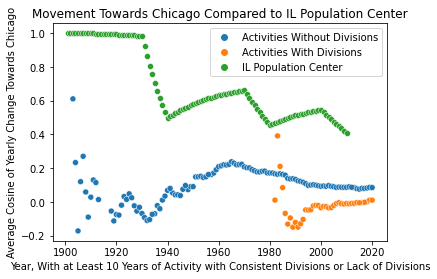

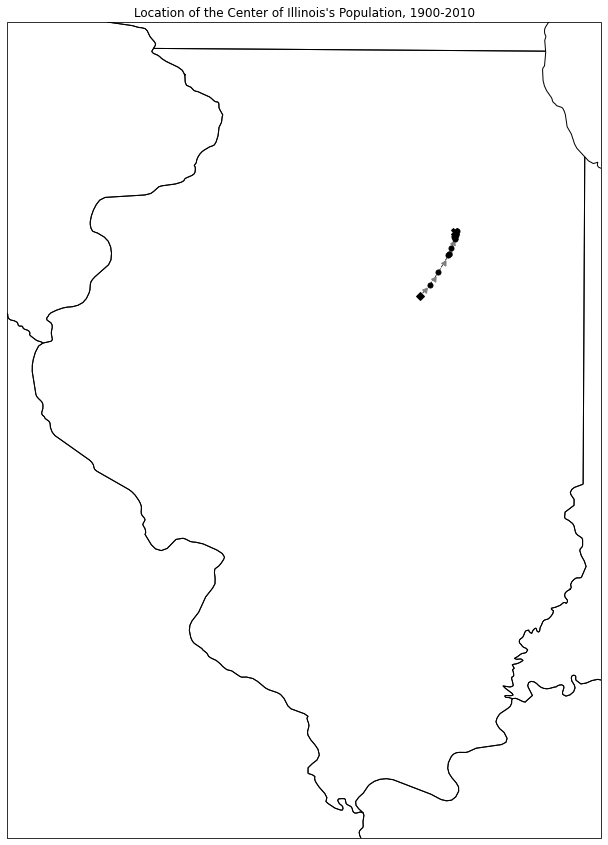

In [35]:
from matplotlib.lines import Line2D
dataset = avg_cos_to_plotter(ihsa_tidy, True, by = "divisions?", plot_type = 0, window = 10)
dataset.columns = ["Average Cosine of Yearly Change Towards Chicago", "Year, With at Least 10 Years of Activity with Consistent Divisions or Lack of Divisions", "Divisions"]
sns.scatterplot(x = "Year, With at Least 10 Years of Activity with Consistent Divisions or Lack of Divisions", y = "Average Cosine of Yearly Change Towards Chicago", data = dataset, hue="Divisions")
sns.scatterplot(x = "year", y = "cos", data  = il_data, color=sns.color_palette()[2])

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Activities Without Divisions', markerfacecolor=sns.color_palette()[0], markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Activities With Divisions', markerfacecolor=sns.color_palette()[1], markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='IL Population Center', markerfacecolor=sns.color_palette()[2], markersize=8)]
plt.legend(handles=legend_elements)

plt.title("Movement Towards Chicago Compared to IL Population Center")
plt.show()

figsize = 15
plt.figure(figsize=(figsize, figsize))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-87.4, -91.7, 36.8, 42.7], ccrs.PlateCarree())
ax.add_feature(cartopy.feature.STATES)
plot_points([pre_il_pop], "Illinois Population", scale = 0.25, connected = "True")
plt.title("Location of the Center of Illinois's Population, 1900-2010")
plt.show()

In [18]:
#differences between points, position, and equal weighting
#https://stackoverflow.com/questions/54426845/how-to-check-if-a-pandas-dataframe-contains-only-numeric-column-wise
metadata = []
for abbr in ihsa_tidy["ABBR"].unique():
    this_activity = ihsa_tidy[ihsa_tidy["ABBR"] == abbr.upper()]

    for year in this_activity["YEAR"].unique():
        this_year_activity = this_activity[this_activity["YEAR"] == year].copy()
        for div in this_year_activity["DIV"].unique():
            div_year_abbr = this_year_activity[this_year_activity["DIV"] == div].copy()
            
            eq_lat = (div_year_abbr["LAT"]/div_year_abbr.shape[0]).sum()
            eq_long = (div_year_abbr["LONG"]/div_year_abbr.shape[0]).sum()
            
            if div_year_abbr["PLACE"].apply(lambda x: pd.notnull(pd.to_numeric(x, errors='coerce'))).all():
                div_year_abbr["PLACE"] = pd.to_numeric(div_year_abbr["PLACE"], downcast='integer')
                control = div_year_abbr["PLACE"].max() + 1
                pl_lat = ((control-div_year_abbr["PLACE"])/(control-div_year_abbr["PLACE"]).sum()*div_year_abbr["LAT"]).sum()
                pl_long = ((control-div_year_abbr["PLACE"])/(control-div_year_abbr["PLACE"]).sum()*div_year_abbr["LONG"]).sum()
                place_tf = True
            else:
                place_tf = False
            
            if div_year_abbr["SCORE"].apply(lambda x: pd.notnull(pd.to_numeric(x, errors='coerce'))).all(): 
                div_year_abbr["SCORE"] = pd.to_numeric(div_year_abbr["SCORE"], downcast='float')
                pt_lat = ((div_year_abbr["SCORE"])/(div_year_abbr["SCORE"].sum())*div_year_abbr["LAT"]).sum()
                pt_long = ((div_year_abbr["SCORE"])/(div_year_abbr["SCORE"].sum())*div_year_abbr["LONG"]).sum()
                points_tf = True
            else:
                points_tf = False
                
            toAppend = np.full((6, 1), np.nan)
            if place_tf:
                toAppend[0] = eq_long - pl_long
                toAppend[1] = eq_lat - pl_lat
            if points_tf:
                toAppend[2] = eq_long - pt_long
                toAppend[3] = eq_lat - pt_lat
            if place_tf and points_tf:
                toAppend[4] = pl_long - pt_long
                toAppend[5] = pl_lat - pt_lat

            metadata.append(toAppend)

In [19]:
eq_minus_pl = []
for x in metadata:
    if not np.isnan(x[0][0]):
        eq_minus_pl.append([x[0][0], x[1][0]])
        
eq_minus_pt = []
for x in metadata:
    if not np.isnan(x[2][0]):
        eq_minus_pt.append([x[2][0], x[3][0]])
        
pt_minus_pl = []
for x in metadata:
    if not np.isnan(x[4][0]):
        pt_minus_pl.append([x[4][0], x[5][0]])

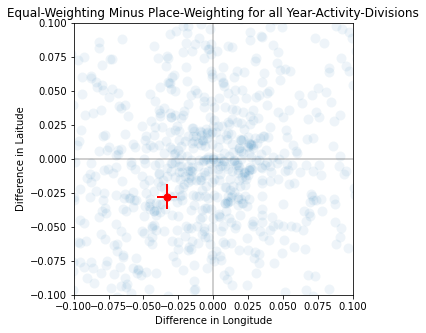

In [20]:
figsize = 5
data = eq_minus_pl
data = pd.DataFrame(data, columns = ["Long", "Lat"])

import statsmodels.stats.weightstats as sm

plt.figure(figsize=(figsize, figsize))

plt.axhline(color = "k", alpha=0.25)
plt.axvline(color = "k", alpha=0.25)
sns.scatterplot(x = "Long", y = "Lat", data = data, alpha = 0.075, s = 100)
plt.plot(data["Long"].mean(), data["Lat"].mean(), marker='o', markersize=7, color = "red")
conf_int = sm.DescrStatsW(data["Long"]).tconfint_mean()
low, high = conf_int[0], conf_int[1]
plt.plot([low, high], [data["Lat"].mean(), data["Lat"].mean()], linestyle='-', linewidth=2, color = "red")
conf_int = sm.DescrStatsW(data["Lat"]).tconfint_mean()
low, high = conf_int[0], conf_int[1]
plt.plot([data["Long"].mean(), data["Long"].mean()], [low, high], linestyle='-', linewidth=2, color = "red")
plt.xlabel("Difference in Longitude")
plt.ylabel("Difference in Laitude")
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.title("Equal-Weighting Minus Place-Weighting for all Year-Activity-Divisions")
plt.axis(True)
plt.show()

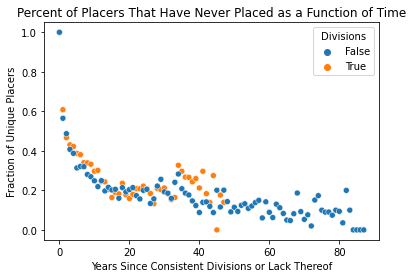

In [21]:
def uniques_over_time(ihsa_subset, normalized = False, relative = True):
    uniques = []
    for abbr in ihsa_subset["ABBR"].unique():
        this_abbr = ihsa_subset[ihsa_subset["ABBR"]==abbr]
        for gl_div in this_abbr["GL_DIV"].unique():
            this_gl_div = this_abbr[this_abbr["GL_DIV"]==gl_div]
            old_schools = []
            first_year = this_gl_div["YEAR"].min()
            running_uniques = 0
            running_totals = 0
            for year in this_gl_div["YEAR"].unique():
                this_year_uniques = 0
                this_year_totals = 0
                this_year = this_gl_div[this_gl_div["YEAR"]==year]
                for school in this_year["SCHOOL"].unique():
                    if school not in old_schools:
                        old_schools.append(school)
                        this_year_uniques += 1
                    this_year_totals += 1
                running_uniques += this_year_uniques
                running_totals += this_year_totals
                if relative: year_append = year-first_year if year <1926 or abbr != "TRB" or gl_div =="0" else year-1975
                else: year_append = year
                #if this_year_uniques/this_year_totals > 0.2 and year_append > 50: print(abbr, year)
                uniques.append([year_append, abbr, this_year_uniques/this_year_totals, running_uniques/running_totals])
    temp= pd.DataFrame(uniques, columns = ["YEAR", "abbr", "Fraction of Uniques", "Running Fraction"])
    uniques = []
    for year in temp["YEAR"].unique():
        if normalized:
            frac_instant = 0
            frac_total = 0
            temp2 = temp[temp["YEAR"]==year]
            for abbr in temp2["abbr"].unique():
                frac_instant += temp2[temp2["abbr"]==abbr]["Fraction of Uniques"].mean()
                frac_total += temp2[temp2["abbr"]==abbr]["Running Fraction"].mean()
            frac_instant = frac_instant / len(temp["abbr"].unique())
            frac_total = frac_total / len(temp["abbr"].unique())
        else:
            frac_instant = temp[temp["YEAR"]==year]["Fraction of Uniques"].mean()
            frac_total = temp[temp["YEAR"]==year]["Running Fraction"].mean()
        uniques.append([year, frac_instant, frac_total])
    return pd.DataFrame(uniques, columns = ["Years Since Consistent Divisions or Lack Thereof", "Fraction of Unique Placers", "Running Fraction of Unique Placers"])


divs = uniques_over_time(ihsa_tidy[ihsa_tidy["GL_DIV"]!="0"])
divs["Divisions"] = True
no_divs = uniques_over_time(ihsa_tidy[ihsa_tidy["GL_DIV"]=="0"])
no_divs["Divisions"] = False

combined = divs.append(no_divs, ignore_index = True)

sns.scatterplot(x="Years Since Consistent Divisions or Lack Thereof", y="Fraction of Unique Placers", data = combined, hue="Divisions")
plt.title("Percent of Placers That Have Never Placed as a Function of Time")
plt.show()

In [22]:
from geopy import distance

def percent_closer_to_chi(ihsa_subset, weighting = "equal", window = 1):
    metadata, goods = return_data(ihsa_subset, weighting = weighting, window = window, to_graph = False)
    num_bigs_closer = 0
    num_smalls_closer = 0

    for abbr in metadata.keys():
        for gl_div in metadata[abbr].keys():
            num_divs = int(gl_div[-1])
            if num_divs > 1:
                for year_data in metadata[abbr][gl_div]:
                    year = year_data[0]
                    small_lat = year_data[1]
                    small_long = year_data[2]
                    small_dist = distance.distance((small_lat, small_long), (41.89188058418812, -87.59885261325608)).miles

                    for greater_gl_div in range(int(gl_div[0])+1, num_divs+1):
                        if str(greater_gl_div) + "/" + str(num_divs) not in metadata[abbr].keys(): print(abbr, year, gl_div)
                        for big_year_data in metadata[abbr][str(greater_gl_div) + "/" + str(num_divs)]:
                            if(big_year_data[0] == year):
                                big_lat = big_year_data[1]
                                big_long = big_year_data[2]
                                big_dist = distance.distance((big_lat, big_long), (41.89188058418812, -87.59885261325608)).miles
                                break
                        if big_dist < small_dist:
                            num_bigs_closer += 1
                        else:
                            num_smalls_closer += 1
    return num_bigs_closer, num_smalls_closer

window_data = []
for i in range(1, 26):
    window_data.append([i, percent_closer_to_chi(ihsa_tidy, window = i)])

3185
3028
2878
2728
2580
2442
2306
2161
2032
1906
1782
1664
1558
1448
1373
1300
1231
1162
1093
1035
979
904
858
812
768


8 0.8604073273440547 0.8777292576419214 0.8950511879397882


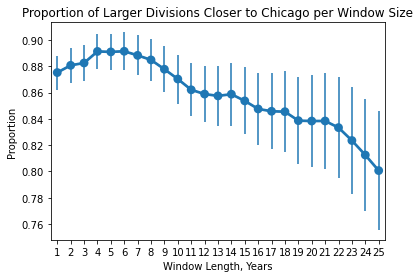

In [23]:
from statsmodels.stats.proportion import proportion_confint
to_display = []
for i in range(len(window_data)):
    conf_int = proportion_confint(window_data[i][1][0], window_data[i][1][0] + window_data[i][1][1], alpha=0.05)
    lb = conf_int[0]
    ub = conf_int[1]
    mid = window_data[i][1][0]/(window_data[i][1][0] + window_data[i][1][1])
    if i == 8: print(i, lb, mid, ub)
    to_display.append([i+1, mid - lb, mid])
to_display = pd.DataFrame(to_display, columns = ["Window", "Interval", "Proportion"])
plt.errorbar(x = np.arange(0,len(to_display)), y = "Proportion", data = to_display, yerr = "Interval")
sns.pointplot(x = "Window", y = "Proportion", data = to_display)
plt.xlabel("Window Length, Years")
plt.ylabel("Proportion")
plt.title("Proportion of Larger Divisions Closer to Chicago per Window Size")
plt.show()

2080


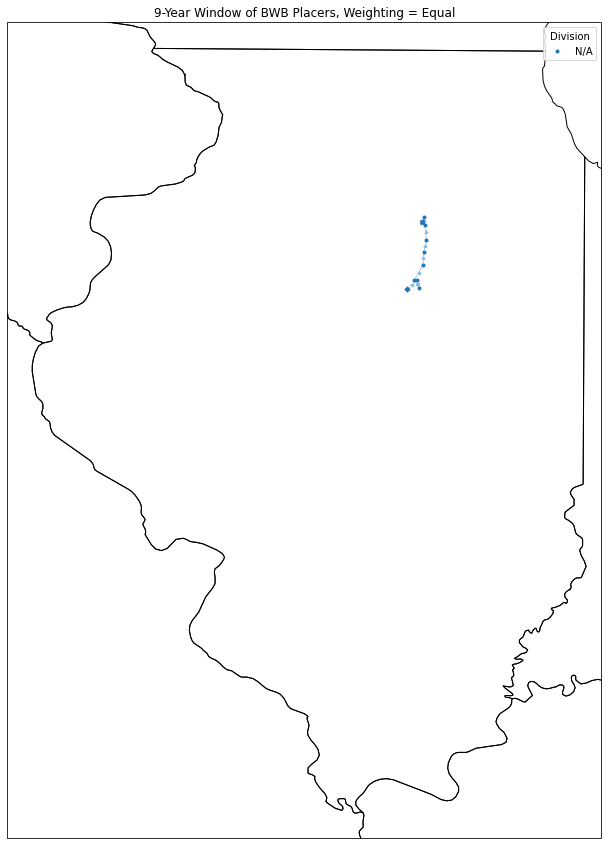

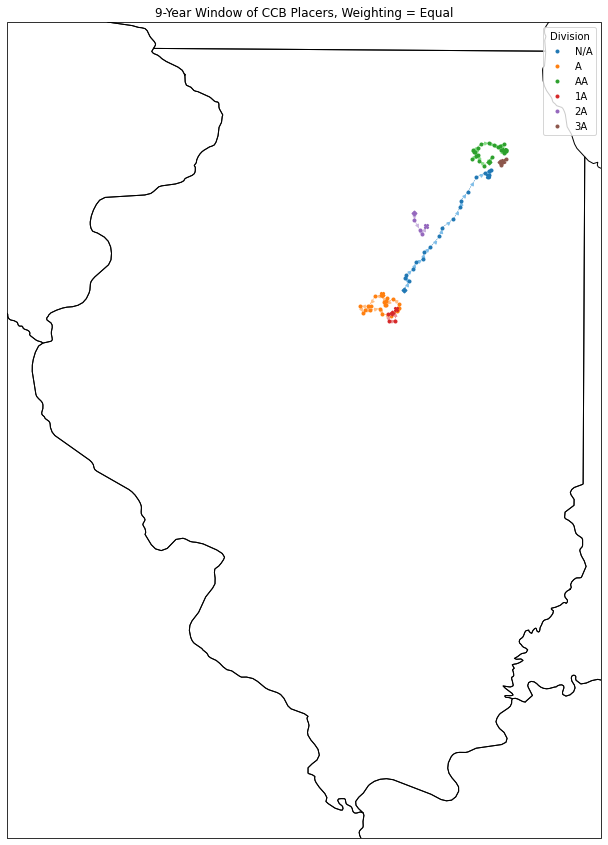

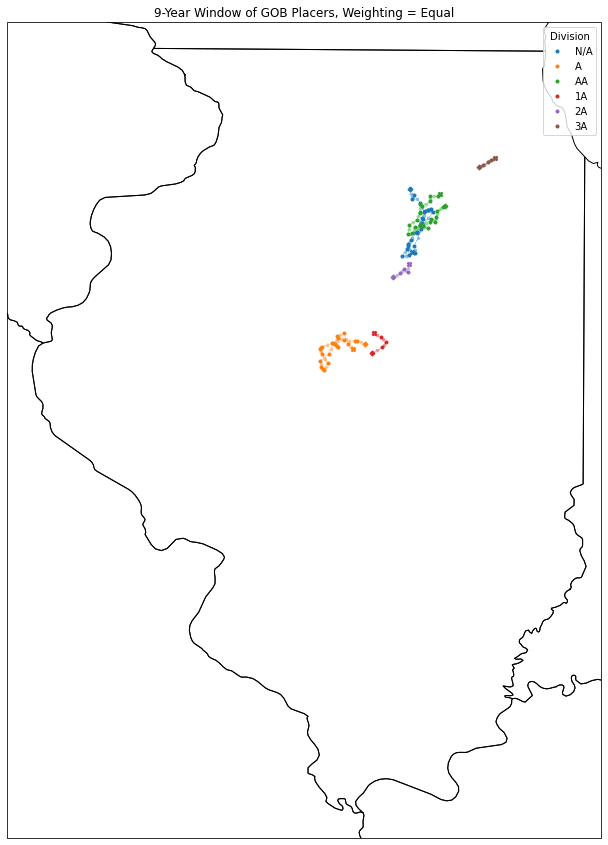

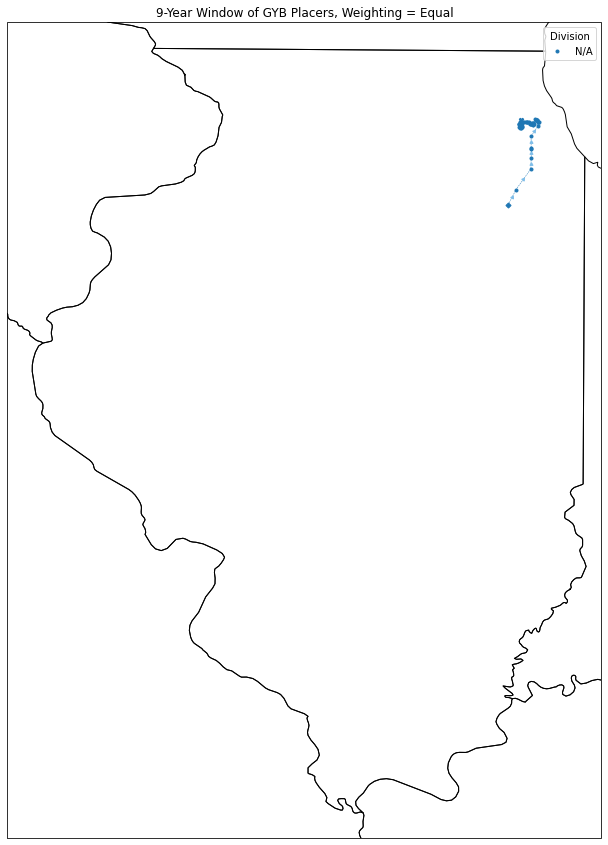

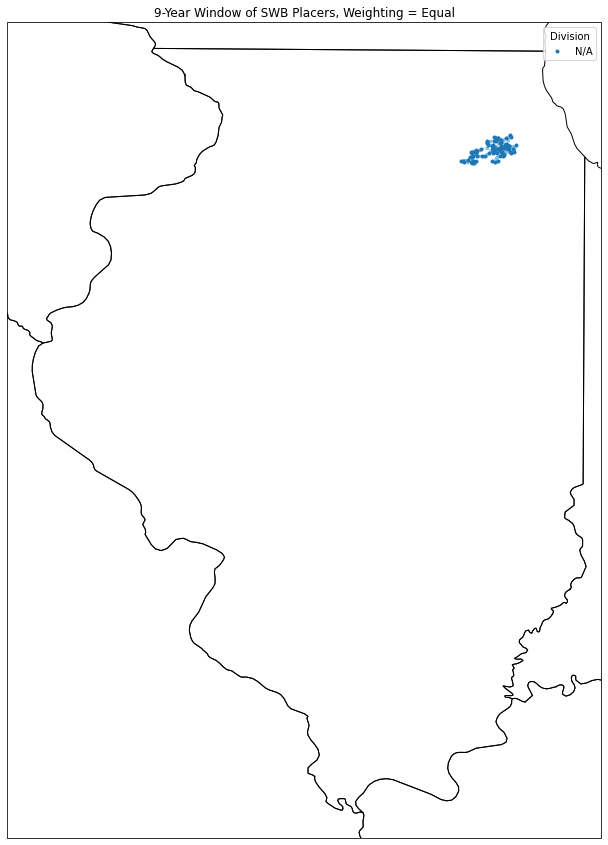

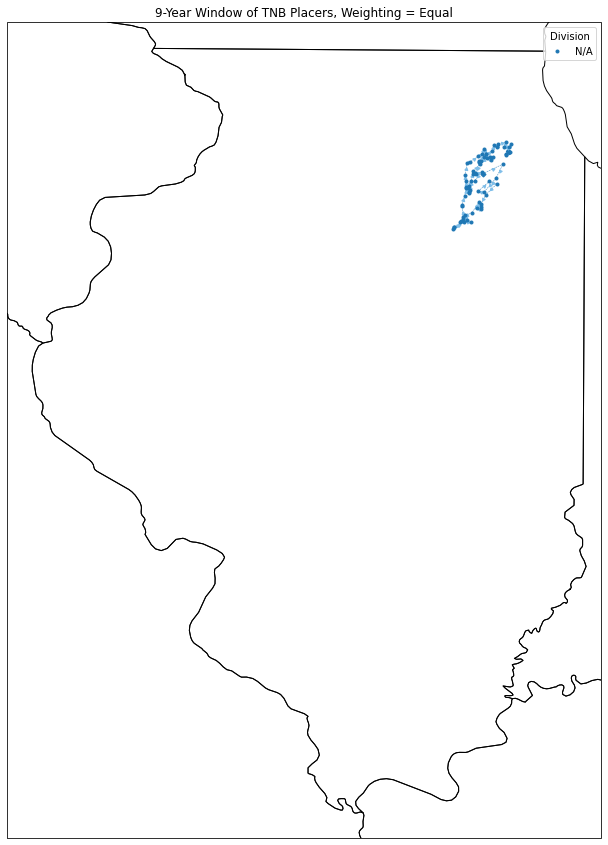

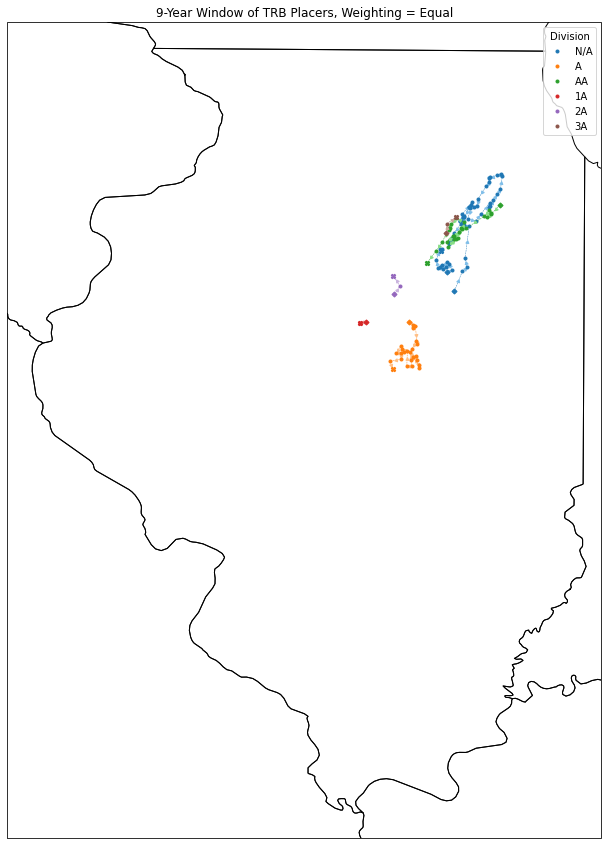

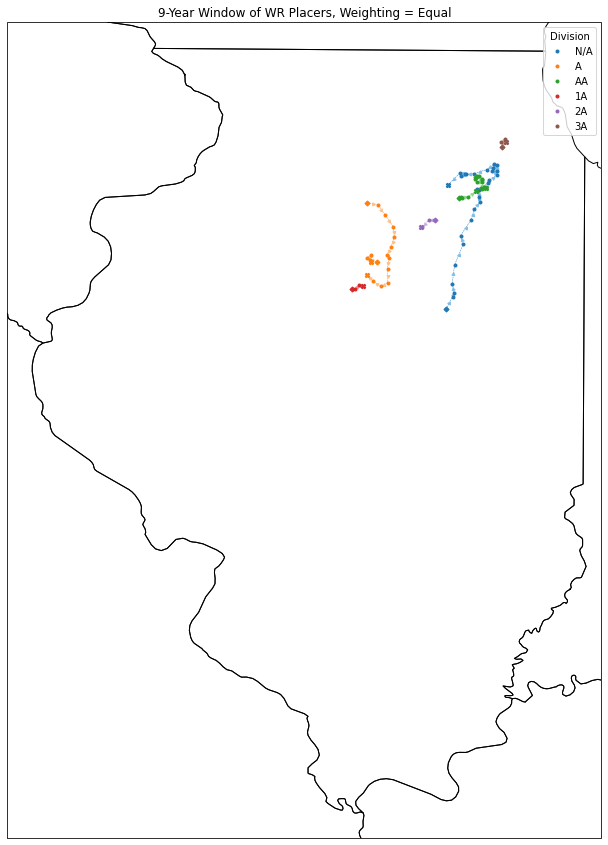

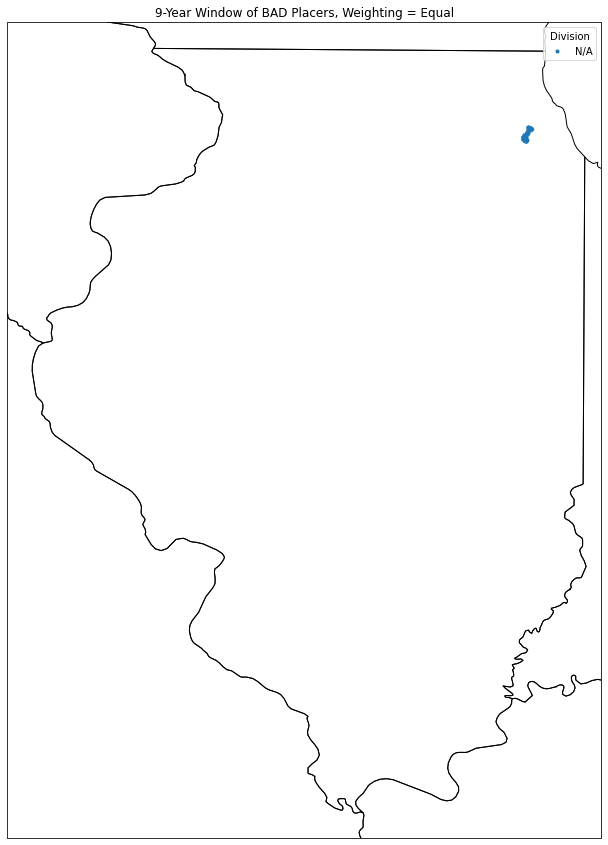

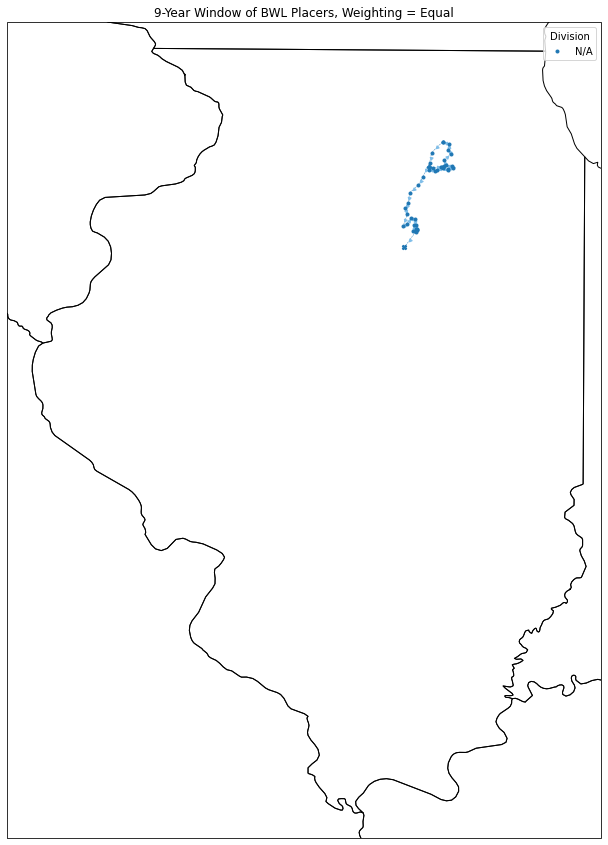

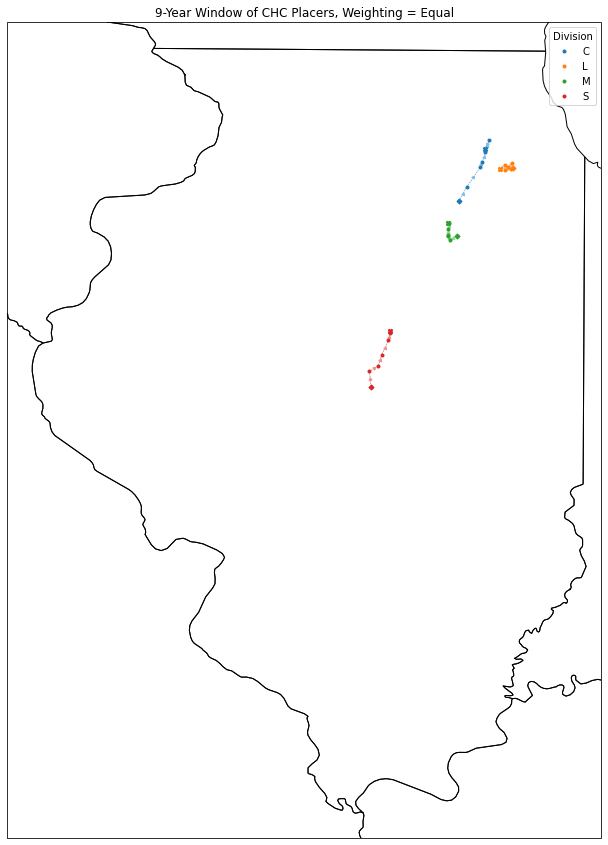

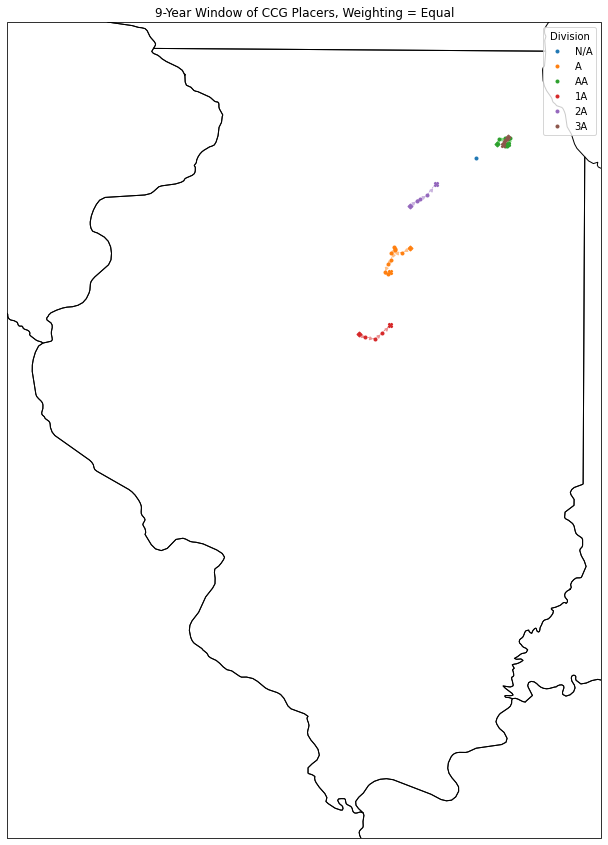

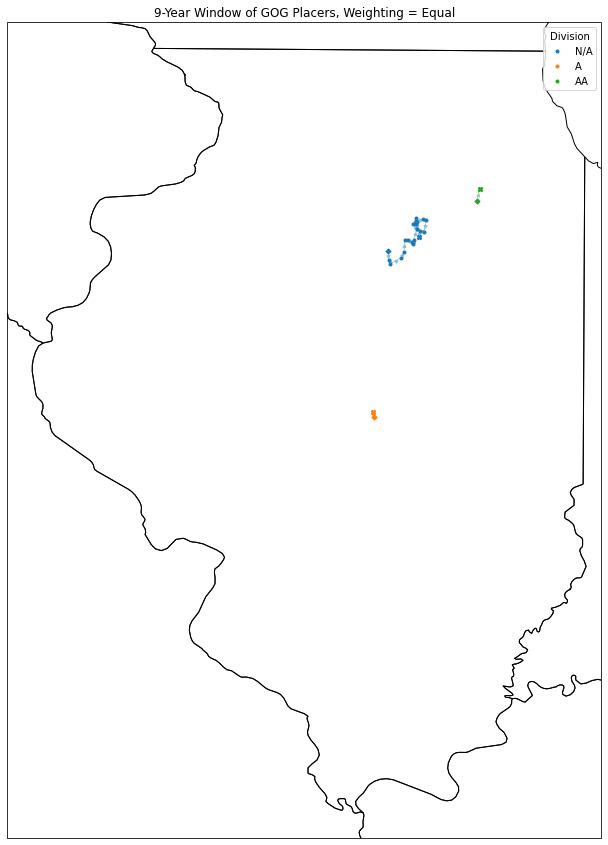

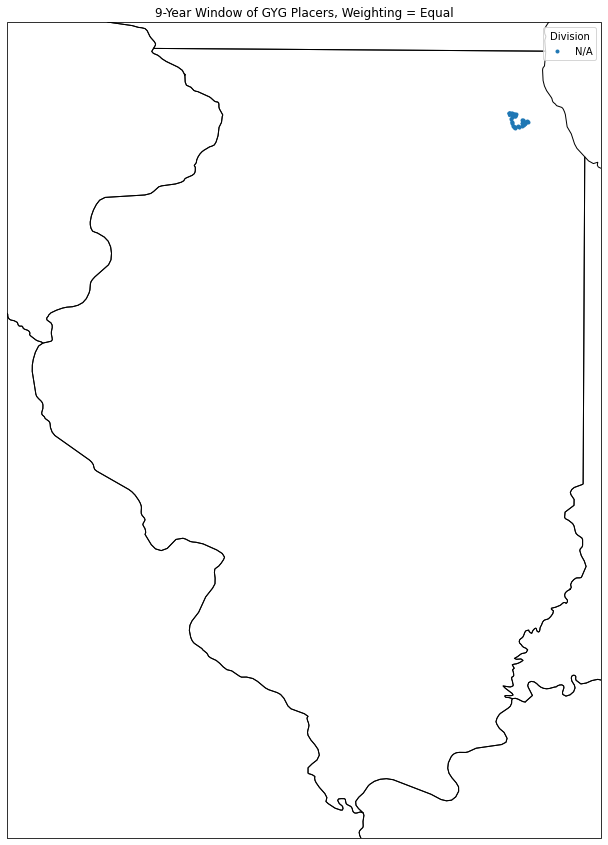

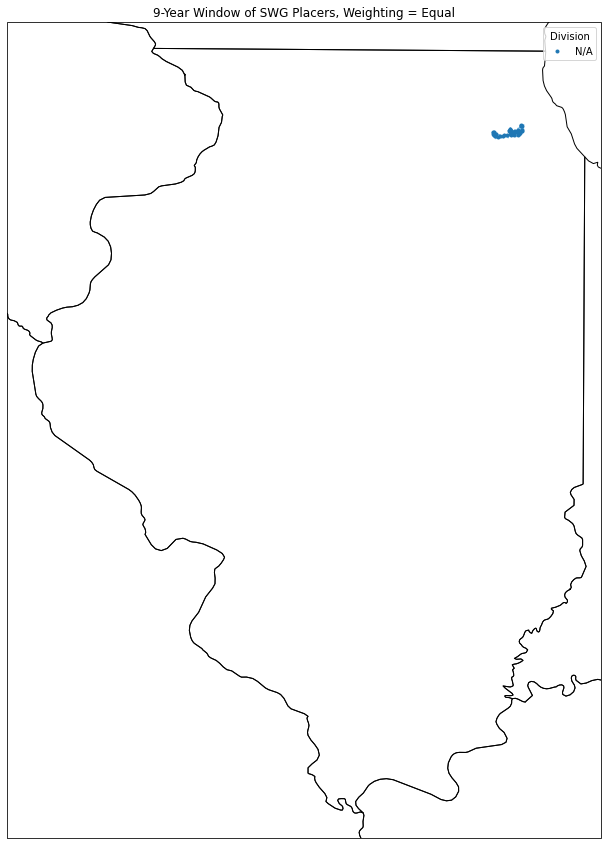

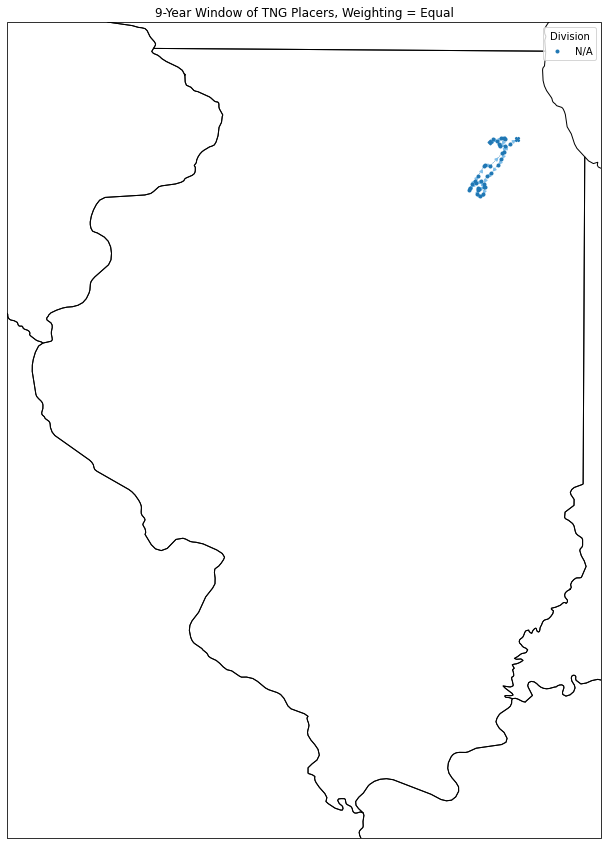

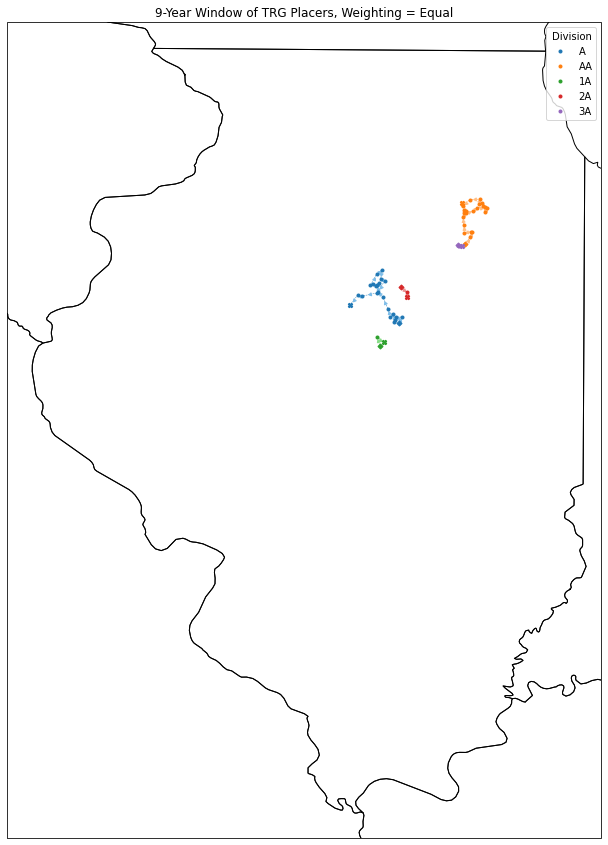

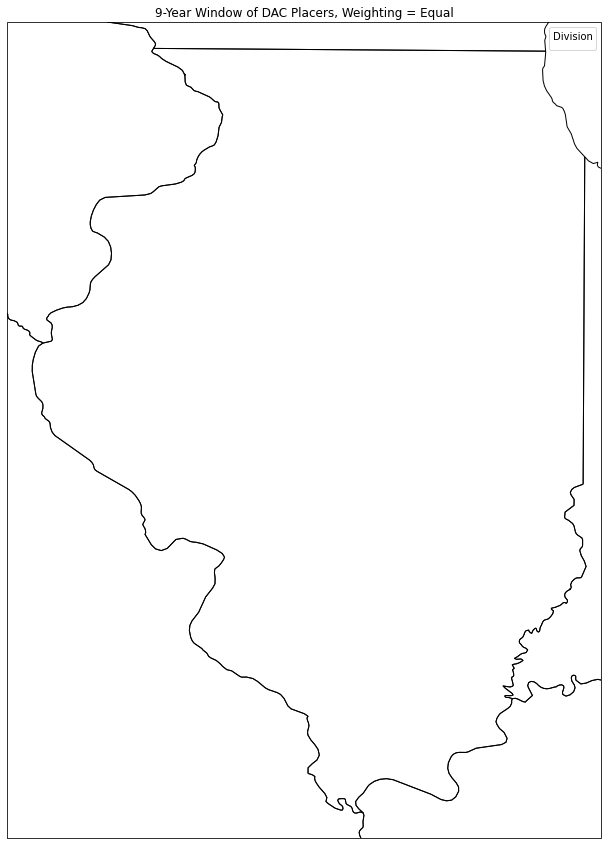

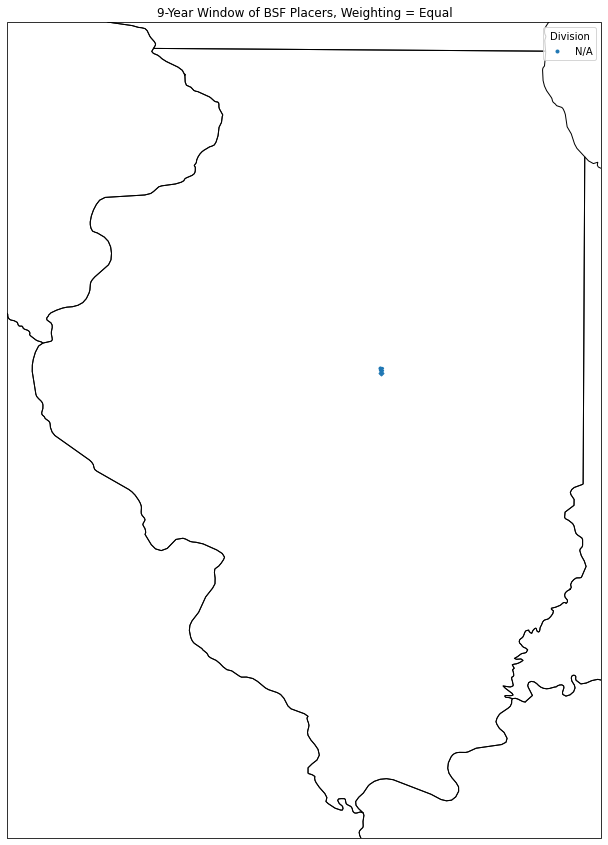

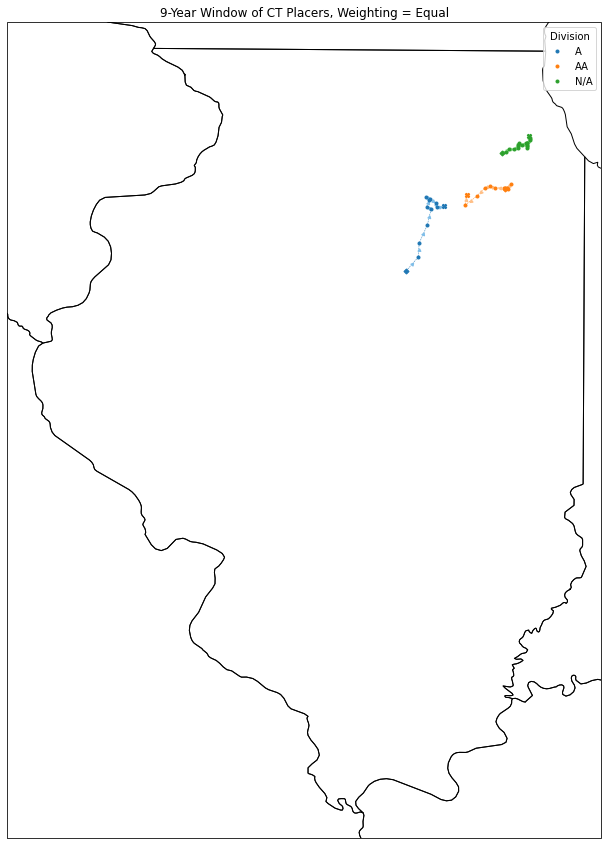

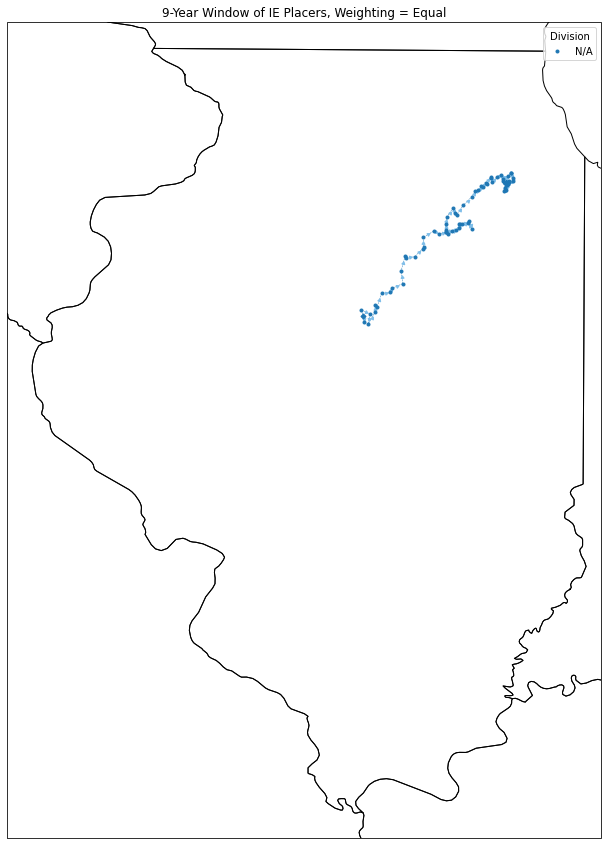

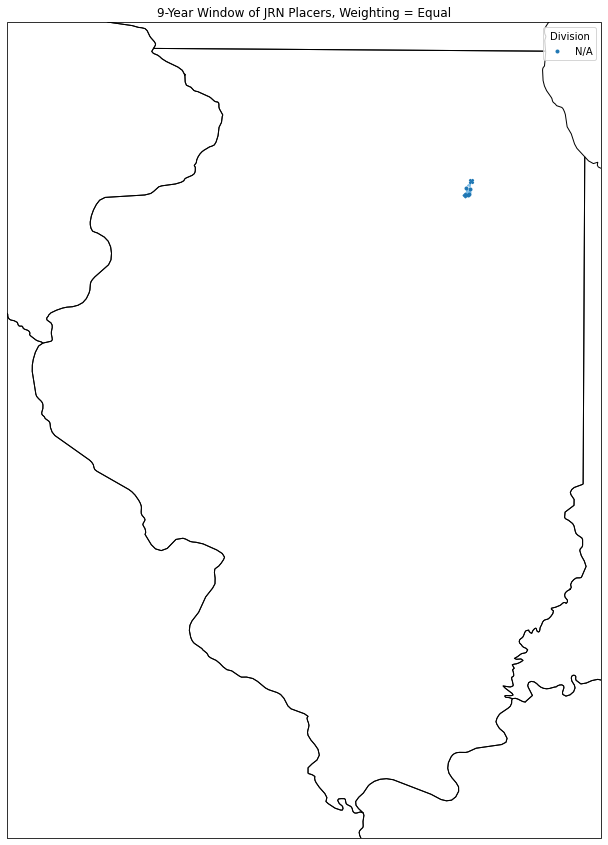

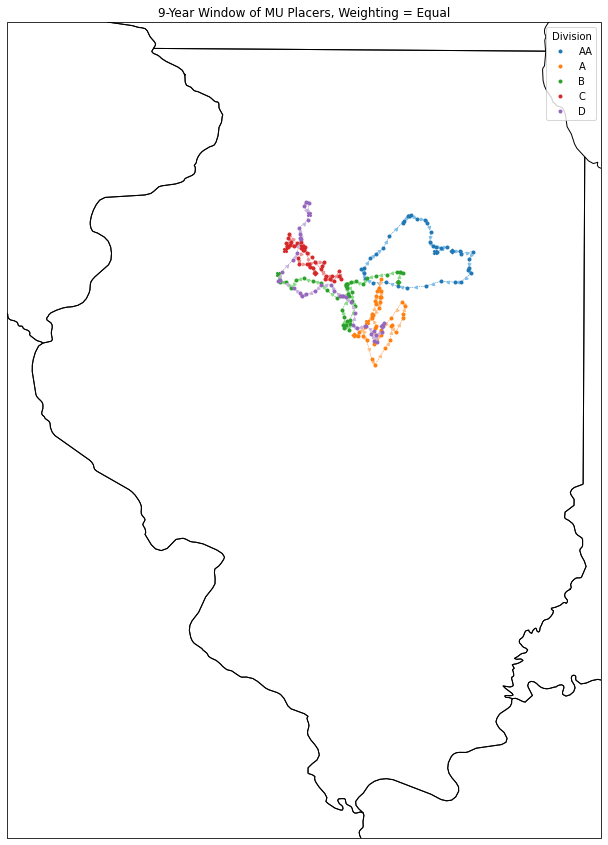

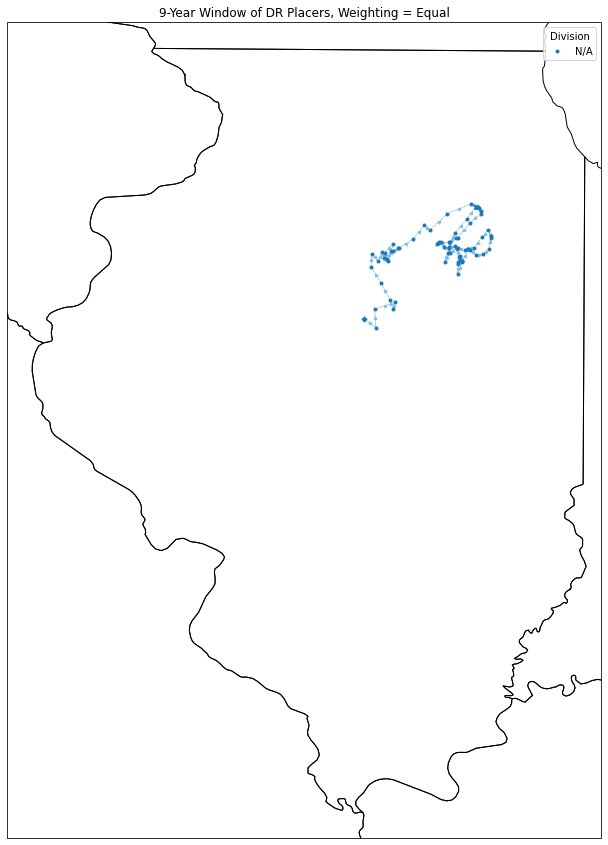

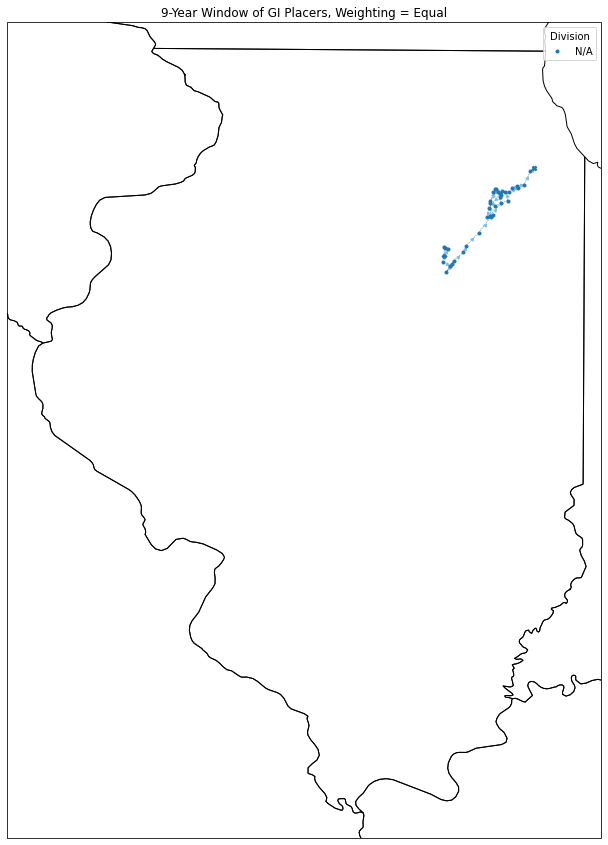

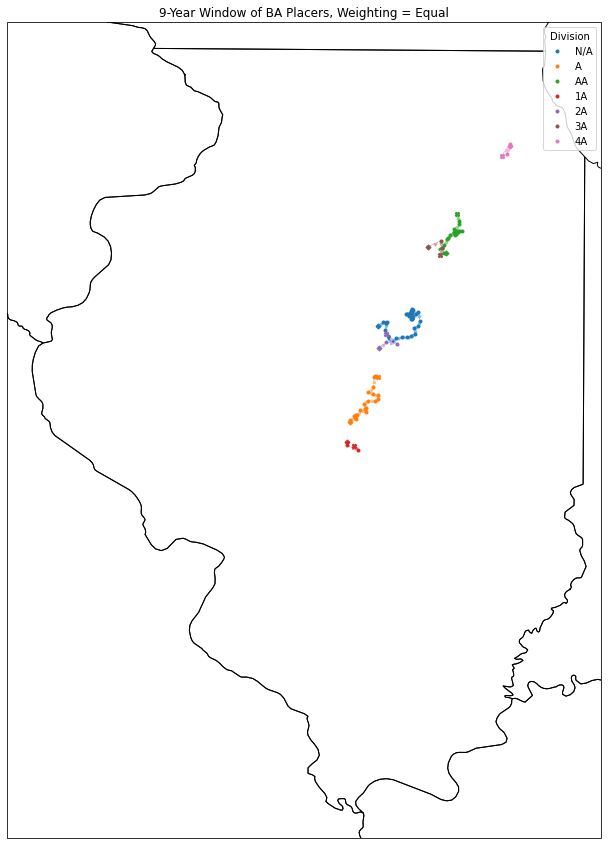

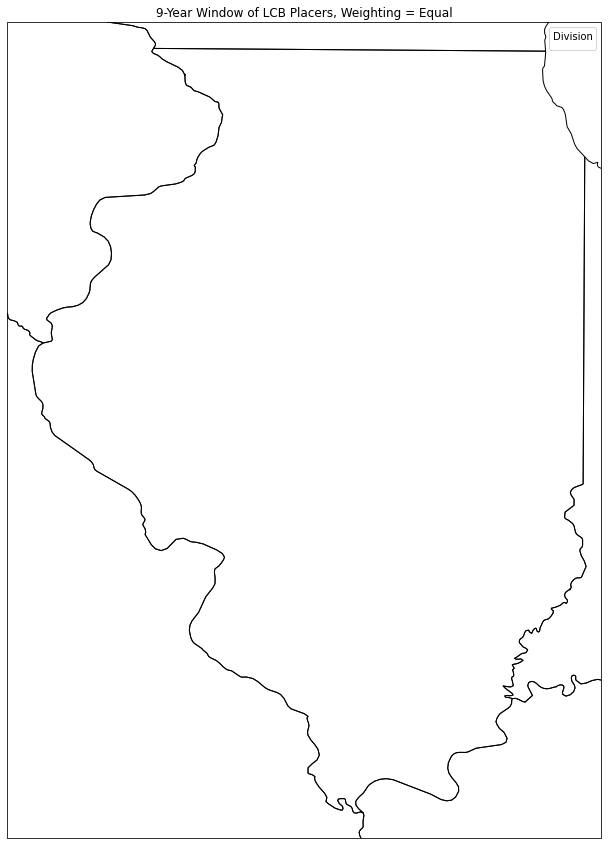

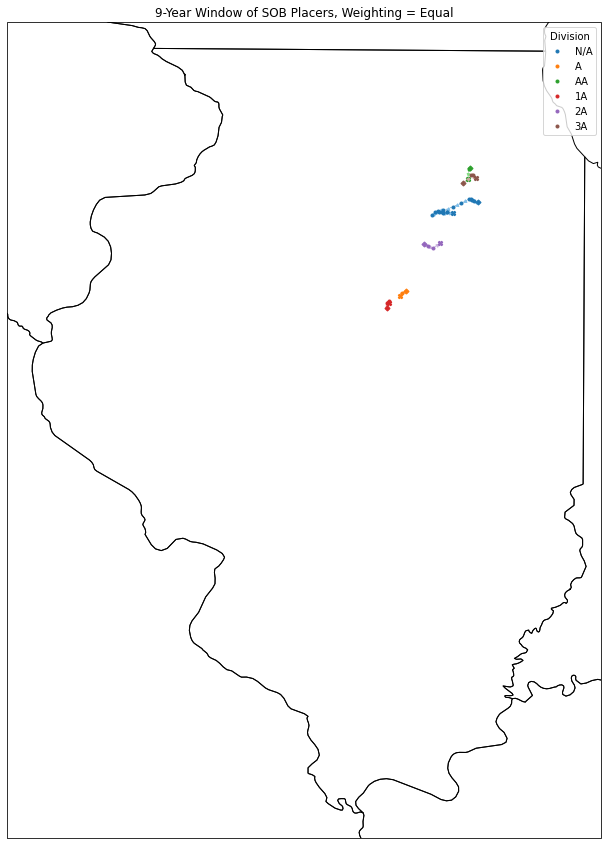

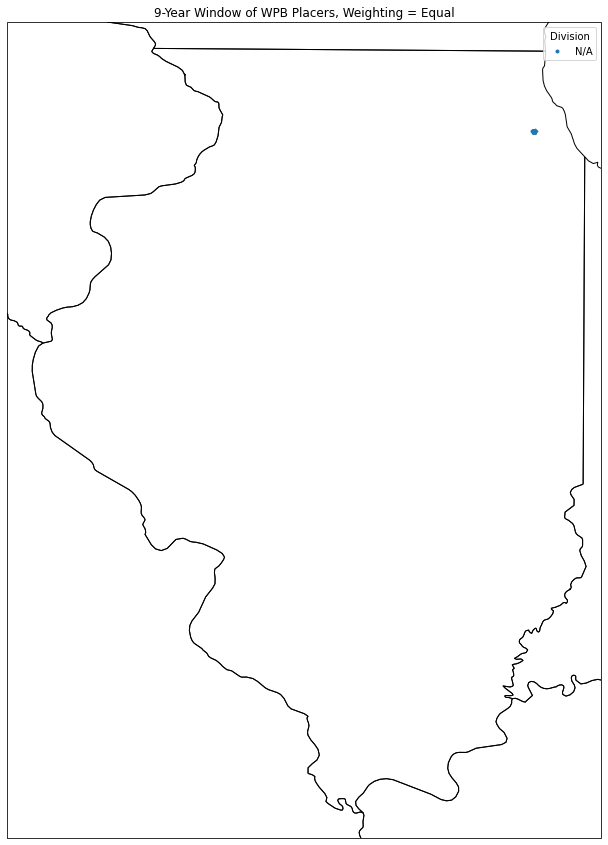

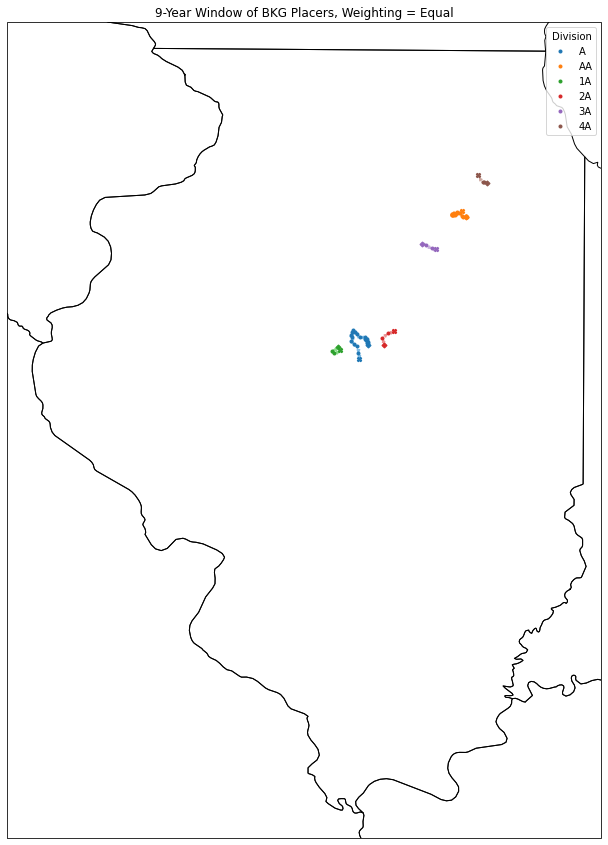

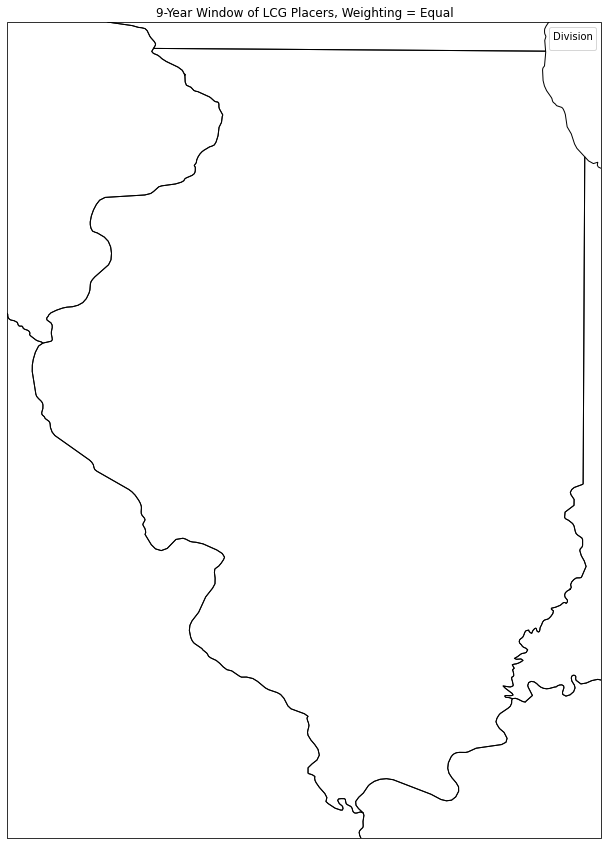

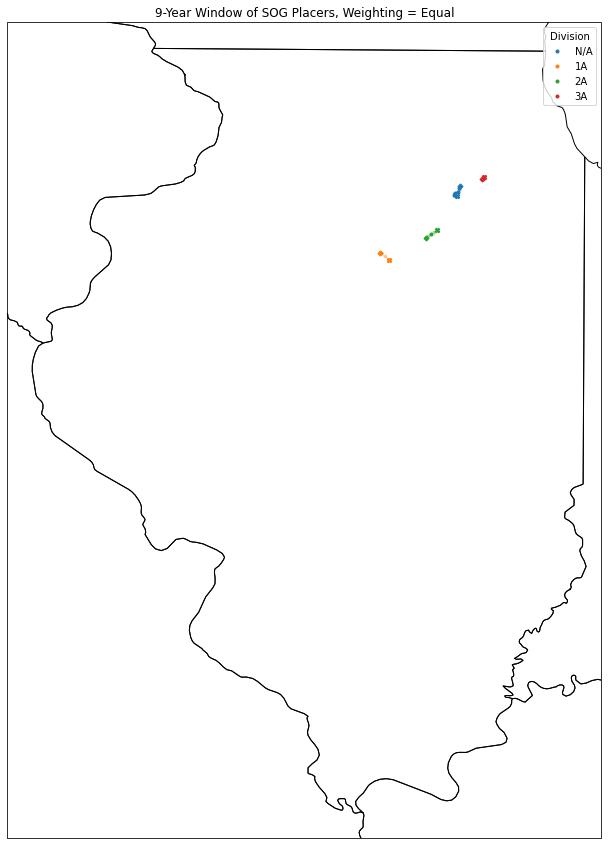

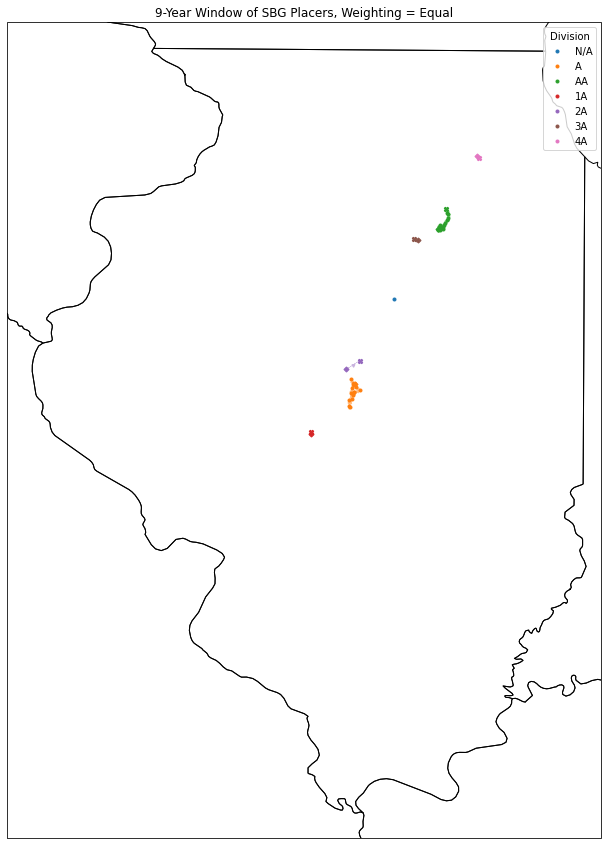

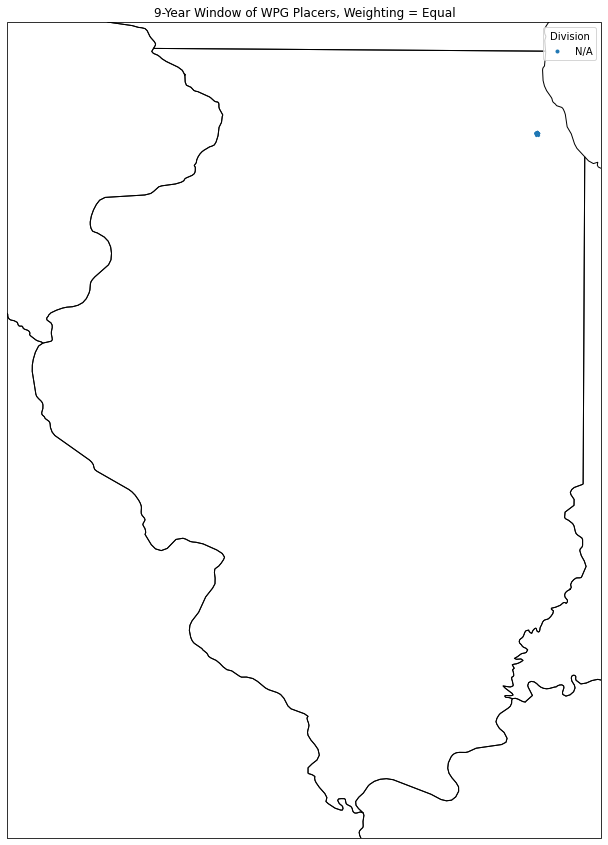

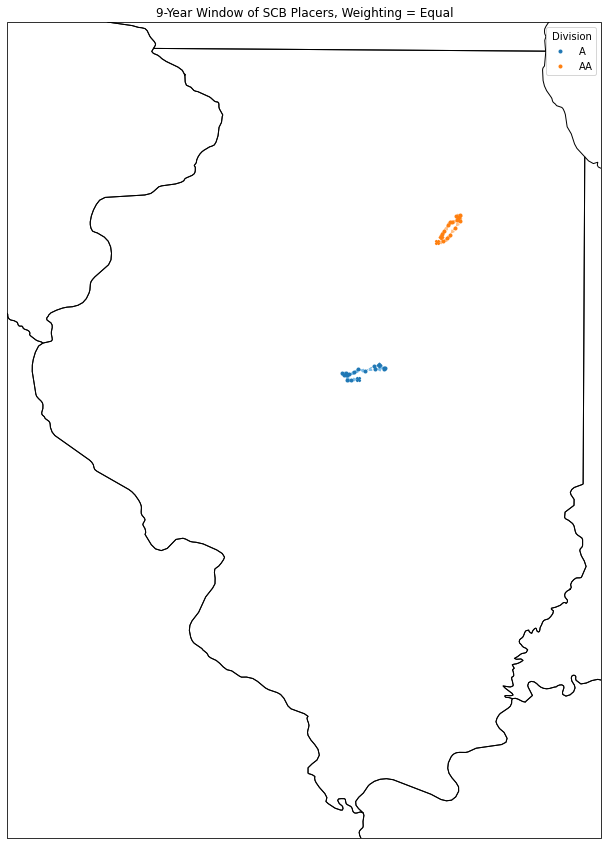

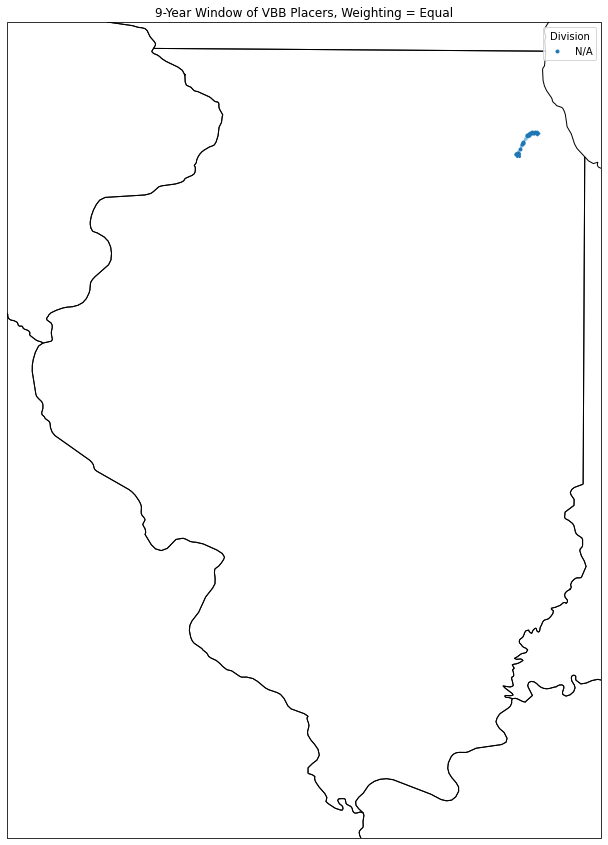

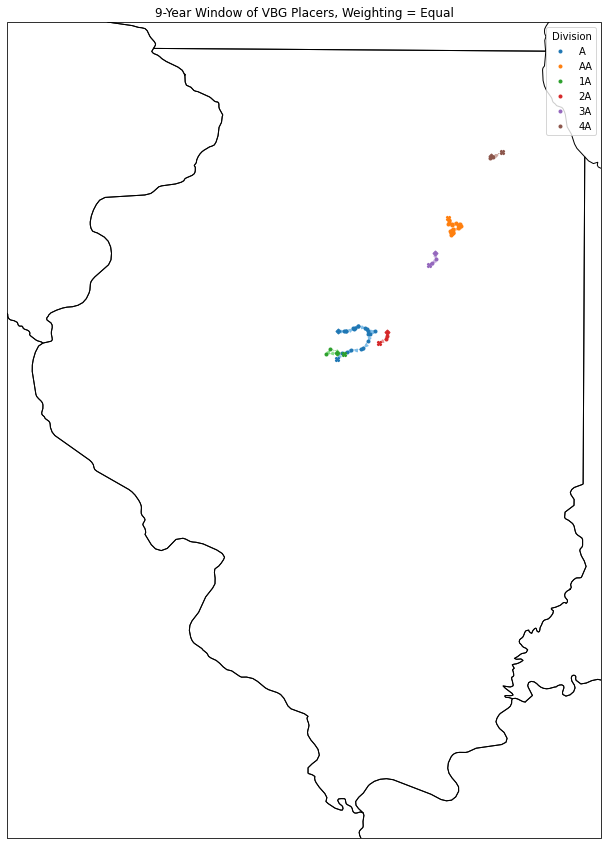

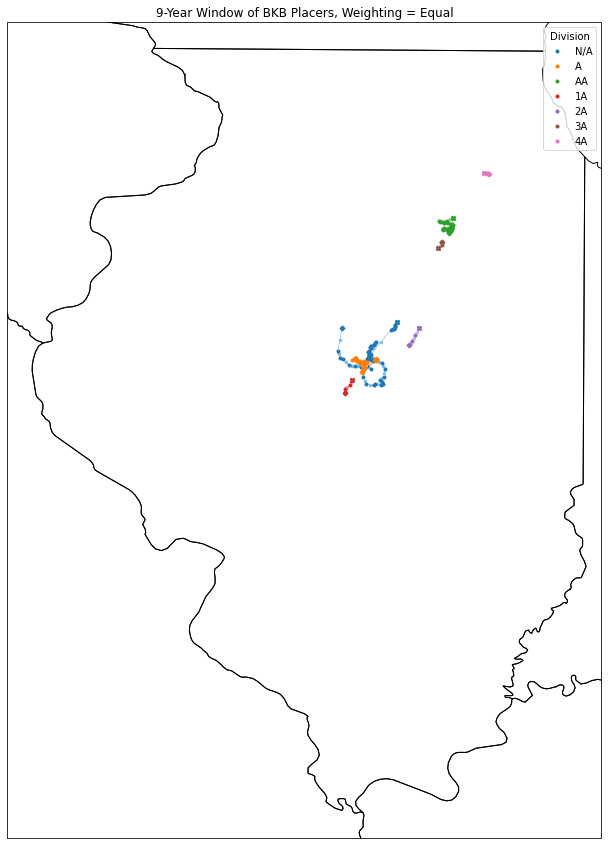

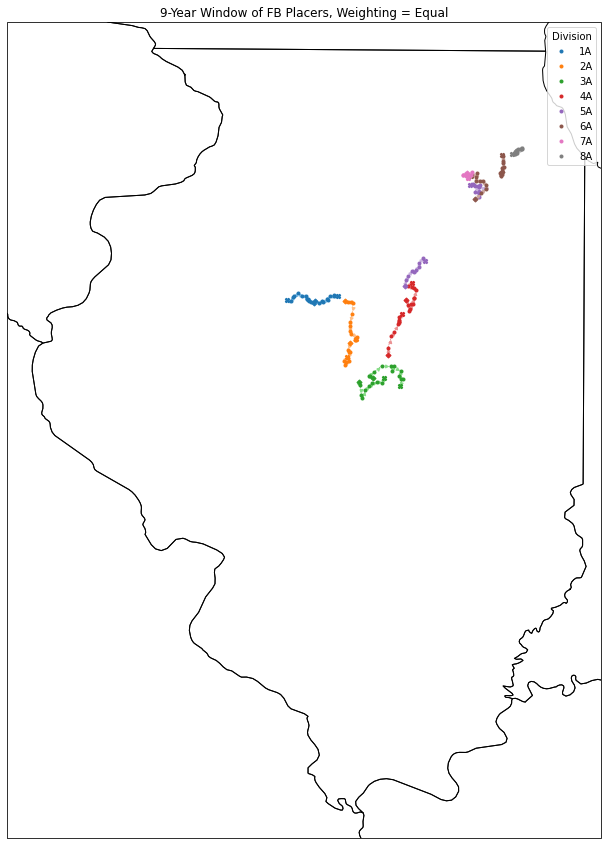

In [89]:
return_graphs(ihsa_tidy, weighting = "equal", connected =True, window = 9, show_map = True, figsize = 15, scale = 0.5)